# TP 3 Dong Qiao yang 1679714 Olivier Provost 1689636 

In [26]:
# Lecture des datasets et des fonctions 
library(Matrix)
u.data <- read.csv(file = 'data.csv', sep='|', header=T)
u.user <- read.csv(file = 'user.csv', sep='|', header=T)
u.item <- read.csv(file = 'item.csv', sep='|', header=T)

mae <- function(m1, m2) mean(abs(m1 - m2), na.rm=T)
rmse <- function(m1, m2) sqrt(mean((m1 - m2)^2, na.rm=T))
matrix.cos <- function(m) {
(m %*% t(m)) / ( t(matrix(sqrt(rowSums(m^2)),nrow(m),nrow(m)))*(sqrt(rowSums(m^2))))
}
mae.rmse <- function(m, m.hat) {
    return(list(mae=mean(abs((m - m.hat)[!is.na(m)]),na.rm=T), rmse=sqrt(mean((m - m.hat)^2, na.rm=T))))
}
colMeans.sparse <- function(m) {colSums(m)/colSums(m>0)}
rowMeans.sparse <- function(m) {rowSums(m)/rowSums(m>0)}
means.sparse <- function(v) {sum(v)/sum(v>0)}


# Trouve les indexes des premieres 'n' valeurs maximales d'une matrice
max.nindex <- function(m, n=5) {
    i <- order(m, decreasing=TRUE)
    return(i[1:n])
}
# Trouve les indexes des premieres 'n' valeurs minimales d'une matrice
min.nindex <- function(m, n=5) {
    i <- order(m)
    return(i[1:n])
}
cosinus.vm <- function(v,m) { 
    n <- sqrt(colSums(m^2)); 
    (v %*% m)/(n * sqrt(sum(v^2)))
}

In [8]:
# Lecture de la matrice
m <- sparseMatrix(u.data[,1],u.data[,2],x=u.data[,3])
rownames(m) <- paste('u', 1:nrow(m), sep='')
colnames(m) <- paste('i', 1:ncol(m), sep='')
m <- as.matrix(m)
m.na <- m
m.full <- m
m.na[m==0] <- NA

In [9]:
u.mean <- matrix(rowMeans(m.na, na.rm=T), nrow(m), ncol(m))
item.mean <- matrix(colMeans(m.na, na.rm=T), nrow(m), ncol(m), byrow=T)
m.expect <- ((u.mean + item.mean)/2)
corner <- function(m, ...) head(t(tail(t(m), ...)), ...)
corner(m.expect)

"[1677,]","[1678,]","[1679,]","[1680,]","[1681,]","[1682,]"
3.305147,2.305147,3.305147,2.805147,3.305147,3.305147
3.354839,2.354839,3.354839,2.854839,3.354839,3.354839
2.898148,1.898148,2.898148,2.398148,2.898148,2.898148
3.666667,2.666667,3.666667,3.166667,3.666667,3.666667
2.937143,1.937143,2.937143,2.437143,2.937143,2.937143
3.317536,2.317536,3.317536,2.817536,3.317536,3.317536


1) On établit performance minimal: moyenne des lignes et colonnes 

On se trompe en moyenne de 0.78 par prédiction avec ce baseline.
Le mae du svd est espéré à un résultat meilleur que 0.78 sinon la méthode n'en vaut pas la chandelle.

In [10]:
mae(m.expect, m.na)

[1] 0.7825831

On remplie la matrice avec la moyenne des lignes et colonnes.

In [11]:
m.full[m==0] <- m.expect[m==0]
# Normaliser la matrice en enlevant la moyenne des lignes de la matrice
rowM <- rowMeans(m.full)
m.full <- m.full - rowM
m.svd <- svd(m.full)

3) 4) Effectuez l'estimation des votes sur la base de SVD avec 10 dimensions et calculez l'erreur absolue moyenne et l'erreur quadratique moyenne.

In [12]:
# Fonction qui applique SVD pour un nombre de dimensions et retournes le MAE et le RMSE
new.m.mae.rmse <- function(dimRedu){
# matrice diagonale pour réduire les matrices originales
m.d2 <- diag(c(m.svd$d[1:dimRedu],rep(0,length(m.svd$d)-dimRedu)))
    
# nouvelle matrice basée sur les n premières dimensions uniquement
m.svd2 <- m.svd$u %*% m.d2 %*% t(m.svd$v)
mae.rmse(m.svd2 + rowM, m.na)
    }
new.m.mae.rmse(10)

$mae
[1] 0.6877558

$rmse
[1] 0.8689911

On remarque ici qu'en réduisant la dimension à 10, on obteint un mae de 0.687, qui est meilleur que la performance minimale. Cette erreur est petite car il n'y a pas de validation croisee.

5) Déterminez le nombre de dimensions optimal (sans appliquer de validation croisée). Un graphique doit indiquer la performance par nombre de dimension (semblable au rapport Sarwar et al.)

In [13]:
# Calcul du mae en itération pour trouver la valeur minimale 
new.m <- function(dimRedu){
# matrice diagonale pour réduire les matrices originales
m.d2 <- diag(c(m.svd$d[1:dimRedu],rep(0,length(m.svd$d)-dimRedu)))
# nouvelle matrice basée sur les deux premières dimensions uniquement
m.svd2 <- m.svd$u %*% m.d2 %*% t(m.svd$v)
mae(m.svd2 + rowM, m.na)
    }
to.plot.1 <- lapply(seq(1,943,20), new.m)


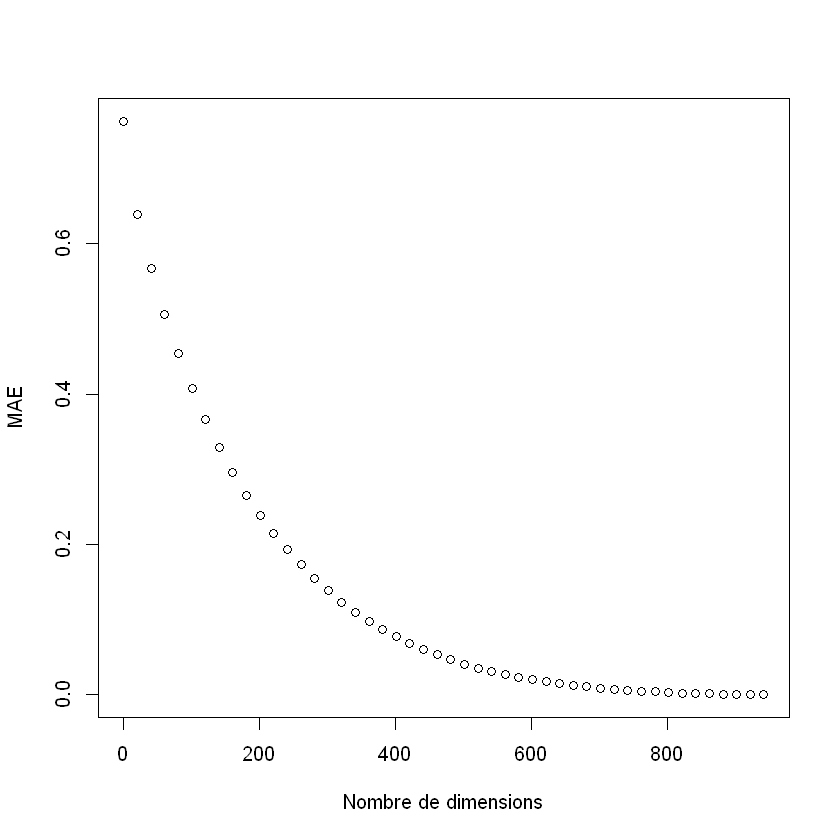

In [14]:
plot(seq(1,943,20),unlist(to.plot.1),ylab = 'MAE',xlab = 'Nombre de dimensions')

In [15]:
new.m(943)

[1] 3.402185e-15

En observant le graphique, 943 est le nombre de dimension optimal puisque son mae est minimal 

Selon ce graphique, plus que le nombre de dimension est grand, plus que le mae est petit. 

Ici le résultat est biaisé puisque nous ne faisons pas de validation croisée. Plus on gardera de dimension, plus le résultat sera prêt de la matrice initial.

En plus, plus le nombre de dimension se rapproche du nombre maximale de dimension, le mae par le svd se rapproche 0 puisqu'on reconstrure la matrice originale. Or pour nombre de dimension de svd = nombre de dimension de la matrice originale, on reconstruit la matrice originale. 

On observe aussi que le mae n'est pas égal à 0 pour le nombre de dimension = 943, erreur d'arrondi. 

6) Déterminez le nombre optimal de dimensions, mais en utilisant cette fois une validation croisée.

In [16]:
new.m.cv <- function(dimRedu){
# matrice diagonale pour réduire les matrices originales
m.d2 <- diag(c(m.svd$d[1:dimRedu],rep(0,length(m.svd$d)-dimRedu)))
# nouvelle matrice basée sur les deux premières dimensions uniquement
m.svd2 <- m.svd$u %*% m.d2 %*% t(m.svd$v)+r.means
mae(m.svd2[i.test.b], m.na[i.test.b])
    }

In [17]:
set.seed(1)
to.plot <- c()
mae.svd <- list()
i.observed <- which(m > 0)
i.hasard <- sample(i.observed, length(i.observed))
fold.size <- round(length(i.hasard) / 5)
i.false <- rep(FALSE, length(m))
for (i in seq_len(5)){
fold.number <- i

## Index booléen pour les cellules de test et d'entraînement
i.test.b <- i.false
## Les cellules indexées du replis correspondant sont fixées à TRUE pour le test...
i.test.b[ i.hasard[((fold.number-1) * fold.size):((fold.number) * fold.size)] ] <- TRUE
## ...et à FALSE pour l'entraînement
i.train.b <-  !i.test.b
m.train <- m
m.train[i.test.b] <- 0                # on enlève les données de test pour l'entraînement
m.train.na <- m.train
m.train.na[m.train==0]<-NA
    
u.mean <- matrix(rowMeans(m.train.na, na.rm=T), nrow(m), ncol(m))
item.mean <- matrix(colMeans(m.train.na, na.rm=T), nrow(m), ncol(m), byrow=T)
m.expect <- ((u.mean + item.mean)/2)
m.train.na[m.train==0] <-m.expect[m.train==0]

r.means <- rowMeans(m.train.na,na.rm=T)
m.train.na[!is.finite(m.train.na)]<- r.means
r.means <- rowMeans(m.train)
m.train.na <- m.train.na-r.means
m.svd <- svd(m.train.na)
to.plot<-rbind(to.plot,unlist(lapply(seq(50), new.m.cv)))
    }

[1] 0.7875839 0.7749320 0.7643434 0.7638515 0.7623750 0.7606513 0.7590660
 [8] 0.7570411 0.7564194 0.7563435 0.7558856 0.7560264 0.7562262 0.7564247
[15] 0.7563614 0.7566665 0.7569623 0.7567779 0.7566020 0.7569411 0.7571881
[22] 0.7575049 0.7578063 0.7581228 0.7583268 0.7585091 0.7589965 0.7593046
[29] 0.7592682 0.7596551 0.7599443 0.7603103 0.7605533 0.7609297 0.7613437
[36] 0.7618813 0.7620677 0.7624157 0.7626900 0.7629515 0.7634245 0.7638167
[43] 0.7641111 0.7643436 0.7646596 0.7650185 0.7653281 0.7654935 0.7658605
[50] 0.7660197

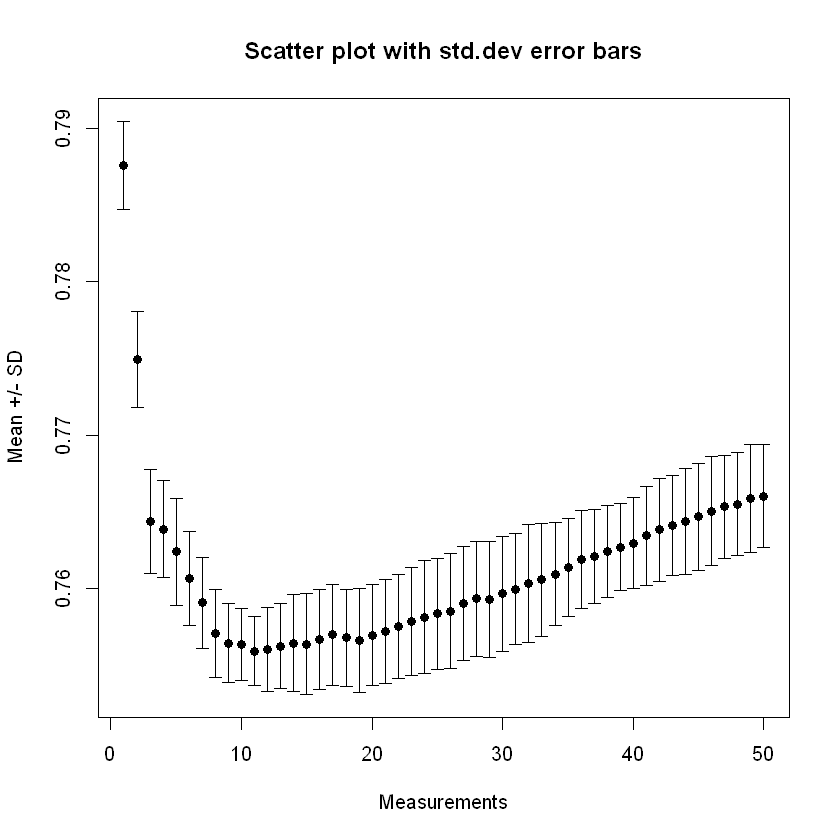

In [18]:
to.plot<-apply(to.plot,2,unlist)
sdev <- apply(to.plot,2,sd) 
avg <- colMeans(to.plot)
avg
x <- 1:length(avg)
plot(x,colMeans(to.plot),ylim=range(c(avg-sdev, avg+sdev)),pch=19, xlab="Measurements", ylab="Mean +/- SD",
    main="Scatter plot with std.dev error bars"
)
# hack: we draw arrows but with very special "arrowheads"
arrows(x, avg-sdev, x, avg+sdev, length=0.05, angle=90, code=3)

En observant le graphique, 11 est le nombre de dimension optimal puisque son mae est minimal.

Avec la validation croisée, on utilise les données d'entrainement pour calcul la nouvelle matrice avec réduction de dimension et nous calculons le mae des données de test afin de déterminer l'hyperparamètre K(nombre de dimension). 

Ceci nous permet d'avoir une meilleure estimation de la valeur optimale de réduction de dimension. 

On voit que le mae diminue avec l'augmentation de dimension jusqu'à 11 et le mae augmente après ce dernier. 

Il n'est dont pas vrai que augmenter le nombre de dimensions à réduire amène nécesairement un meilleur mae avec validation croisée. 

7) Comparez la performance de cette approche avec celle d'une approche collaborative de votre choix (avec l'erreur quadratique et erreur absolue moyennes). Utilisez une validation croisée.

In [27]:
i.observed <- which(m > 0)
set.seed(1)
i.hasard <- sample(i.observed, length(i.observed))
fold.size <- round(length(i.hasard) / 5)
i.false <- rep(FALSE, length(m))
mae.svd <- c()
mae.itemitem <- c()
rmse.svd <- c()
rmse.itemitem <- c()
for (i in seq_len(5)){
fold.number <- i
## Index booléen pour les cellules de test et d'entraînement
i.test.b <- i.false

## Les cellules indexées du replis correspondant sont fixées à TRUE pour le test...
i.test.b[ i.hasard[((fold.number-1) * fold.size):((fold.number) * fold.size)] ] <- TRUE
## ...et à FALSE pour l'entraînement
i.train.b <-  !i.test.b
m.train <- m
m.train[i.test.b] <- 0                # on enlève les données de test pour l'entraînement
m.train.na <- m.train
m.train.na[m.train==0]<-NA
    
u.mean <- matrix(rowMeans(m.train.na, na.rm=T), nrow(m), ncol(m))
item.mean <- matrix(colMeans(m.train.na, na.rm=T), nrow(m), ncol(m), byrow=T)
m.expect <- ((u.mean + item.mean)/2)
m.train.na[m.train==0] <-m.expect[m.train==0]

r.means <- rowMeans(m.train.na,na.rm=T)
r.means.t <- rep(r.means,1682)
m.train.na[!is.finite(m.train.na)]<- r.means
r.means <- rowMeans(m.train)
m.train.na <- m.train.na-r.means
m.svd <- svd(m.train.na)

dimRedu <- 11
m.d2 <- diag(c(m.svd$d[1:dimRedu],rep(0,length(m.svd$d)-dimRedu)))
# nouvelle matrice basée sur les deux premières dimensions uniquement
m.svd2 <- m.svd$u %*% m.d2 %*% t(m.svd$v)+r.means

    
# Question 7 - Validation croisée pour question 3
# Ici nous essayons de prédire les valeurs des votes du film Star trek 5 à l'aide d'une approche item-item
m.sparse <- m
m.sparse[i.test.b]<-0
m.sparse.t <- t(m.sparse)
try <- function(x,y,w) {x.0 <- x>0 ; x.temp <- (x-y)*x.0; num <-  w %*%x.temp;denum <- sum(abs(t(w))*x.0);num/denum} 

film_pred <- function(film_id){
# Pour l'exercise, on choisit de prendre seulement les utilisateurs pour l'item Star Trek V: The Final Frontier
v.item <- m.sparse.t[film_id,]
# Le set est divisé en train set (80%) et test set (20%)
new.m.sparse <- m.sparse

voisins <- 21
# on centre la matrice m selon les utilisateurs
# on calcule la moyenne et centré pour enlever les biais des utilisateurs comme pour la question 4
u.mean <-rowMeans.sparse(new.m.sparse)
m.center <- as.matrix((new.m.sparse-u.mean)*(new.m.sparse>0))
# on remplace les 0 par NA
m.center[m.center==0] <- NA

# on calcule la distance eucledienne entre les films
distance.na.450.center <- sqrt(colSums((m.center[,film_id] - m.center)^2, na.rm=T)) # ignore les valeurs manquantes
# on calcule le nombre de votes communs des films avec star trek V
votes.communs <- (colSums((new.m.sparse[,film_id] * new.m.sparse) > 0))
# on assigne la valeur au film qui ont moins de 40 votes communs avec star trek V
distance.na.450.center[votes.communs<5] <- Inf

closest.euc <- min.nindex(distance.na.450.center, voisins)[-1]

wcos.st <- cosinus.vm(new.m.sparse[,film_id], new.m.sparse[,closest.euc])

# les 20 films les plus communs
idx<- closest.euc
# on transpose m
m.sparse.t <- t(new.m.sparse)
# la range de l item de star trek V
v.item <- m.sparse.t[film_id,]
# la moyenne de l item de star trek V
v_1 <-means.sparse(v.item);
# retourne la moyenne pour chacun des 20 films voisisns
v_i <- apply(m.sparse.t[idx,], 1, FUN=means.sparse)

x<- as.matrix((m.sparse.t[idx,]))
new_x <-lapply(seq_len(ncol(x)), function(i) x[,i]) # Retourne une liste de longeur 943 
new_y <-as.vector(lapply(seq_len(ncol(x)), function(i) v_i)) 
new_w <-as.vector(lapply(seq_len(ncol(x)), function(i) as.matrix(wcos.st)))

    
c_prod <- mapply(try ,new_x, new_y, new_w)
# Ajoute la moyenne de l'item 
v_1+c_prod
}
film_prection_list <-lapply(seq_len(1682), film_pred) # Retourne une liste de longeur 943 
new.matrix <- do.call(cbind, film_prection_list)
mae.temp <- mae(new.matrix[i.test.b&!is.na(new.matrix)], m.na[i.test.b&!is.na(new.matrix)])
rmse.temp <- rmse(new.matrix[i.test.b&!is.na(new.matrix)], m.na[i.test.b&!is.na(new.matrix)])
mae.itemitem <- c(mae.itemitem,mae.temp)
rmse.itemitem <- c(rmse.itemitem,rmse.temp)

    
mae.temp<-mae(m.svd2[i.test.b&!is.na(new.matrix)] , m.na[i.test.b&!is.na(new.matrix)])
rmse.temp<- rmse(m.svd2[i.test.b&!is.na(new.matrix)], m.na[i.test.b&!is.na(new.matrix)])
mae.svd <- c(mae.svd,mae.temp)
rmse.svd <- c(rmse.svd,rmse.temp)
}

In [28]:
mae.svd

[1] 0.7545084 0.7641811 0.7567740 0.7634091 0.7608465

In [29]:
mae.itemitem

[1] 0.9033565 0.9129042 0.9050295 0.9043354 0.9059081

In [30]:
mean(mae.svd)

[1] 0.7599438

In [33]:
mean(rmse.svd)

[1] 0.9519822

In [31]:
mean(mae.itemitem)

[1] 0.9063067

In [32]:
mean(rmse.itemitem)

[1] 1.165036

En utilisant la validaion croisée, le mae de l'approche SVD est meilleure que le mae de l'approche item-item. En plus d'avoir un meilleur MAE et RMSE, SVD fait une prediction pour toute la matrice alors que item-item non. 